#  Chest X-Ray Pneumonia Detection (PyTorch + HuggingFace)
A CPU-optimized CNN for detecting pneumonia using **HuggingFace datasets** - no manual download needed!

**Dataset**: [keremberke/chest-xray-classification](https://huggingface.co/datasets/keremberke/chest-xray-classification)

In [ ]:
# Install required packages
!pip install datasets torch torchvision tqdm scikit-learn seaborn matplotlib pillow -q

### 1.  Imports & Setup / الاستيراد والإعداد
We start by bringing in all the necessary tools (libraries) for our project. Think of this as gathering your ingredients before cooking.

*   **torch & torchvision**: The main tools for building our AI model (PyTorch library).
*   **datasets (HuggingFace)**: Helps us easily download the X-ray images from the internet.
*   **matplotlib & seaborn**: Used for drawing charts and showing images.
*   **sklearn (scikit-learn)**: Tools for measuring how well our model performs.

> **Note:** We also set a "seed" (like `42`) to make sure our results can be repeated (reproducible).

In [ ]:
# Imports
import numpy as np, matplotlib.pyplot as plt, copy
from tqdm.notebook import tqdm
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from datasets import load_dataset
from PIL import 

np.random.seed(42); torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch {torch.__version__} on {device}")

PyTorch 2.9.1+cpu on cpu


### 2.  Configuration / الإعدادات
Here we define the "rules" for our training process.
*   **IMG_SIZE = 128**: We resize all X-rays to 128x128 pixels. Smaller images make the AI learn faster.
*   **BATCH_SIZE = 32**: The model learns from 32 images at a time, not one by one. This is faster. (حجم الدفعة)
*   **EPOCHS = 25**: We will force the model to look through the entire dataset 25 times to learn. (عدد الدورات التدريبية)
*   **LR = 0.001 (Learning Rate)**: How fast the model changes its mind. If too high, it misses the target; if too low, it learns too slowly. (معدل التعلم)

In [5]:
# Configuration
class Config:
    IMG_SIZE = 128  # Can reduce to 64 for faster training
    BATCH_SIZE = 32
    EPOCHS = 25
    LR = 0.001
config = Config()

##  Load Dataset from HuggingFace
This will **automatically download** the dataset (~1.2GB) and cache it for future use.

### 3.  Loading Data / تحميل البيانات
We download the chest X-ray dataset automatically from HuggingFace.
*   **Train Set (مجموعة التدريب)**: Used to teach the model (4077 images).
*   **Validation Set (مجموعة التحقق)**: Used to check progress during training (1165 images).
*   **Test Set (مجموعة الاختبار)**: Used for the final exam of the model (582 images).

**Labels (التسميات):**
*   0: NORMAL (سليم)
*   1: PNEUMONIA (مصاب)

In [ ]:
# Load dataset from HuggingFace
print("Loading dataset from HuggingFace...")
dataset = load_dataset("keremberke/chest-xray-classification", "full")
print(f"\nDataset loaded!")
print(f"Train: {len(dataset['train'])} | Validation: {len(dataset['validation'])} | Test: {len(dataset['test'])}")
print(f"\nLabels: {dataset['train'].features['labels'].names}")

Loading dataset from HuggingFace...


README.md: 0.00B [00:00, ?B/s]

f:\conda\envs\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hesham\.cache\huggingface\hub\datasets--keremberke--chest-xray-classification. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


chest-xray-classification.py: 0.00B [00:00, ?B/s]

full/train/0000.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

full/validation/0000.parquet:   0%|          | 0.00/41.3M [00:00<?, ?B/s]

full/test/0000.parquet:   0%|          | 0.00/20.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4077 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1165 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/582 [00:00<?, ? examples/s]


✅ Dataset loaded!
Train: 4077 | Validation: 1165 | Test: 582

Labels: ['NORMAL', 'PNEUMONIA']


In [7]:
# Get class names
class_names = dataset['train'].features['labels'].names
print(f"Classes: {class_names}")

Classes: ['NORMAL', 'PNEUMONIA']


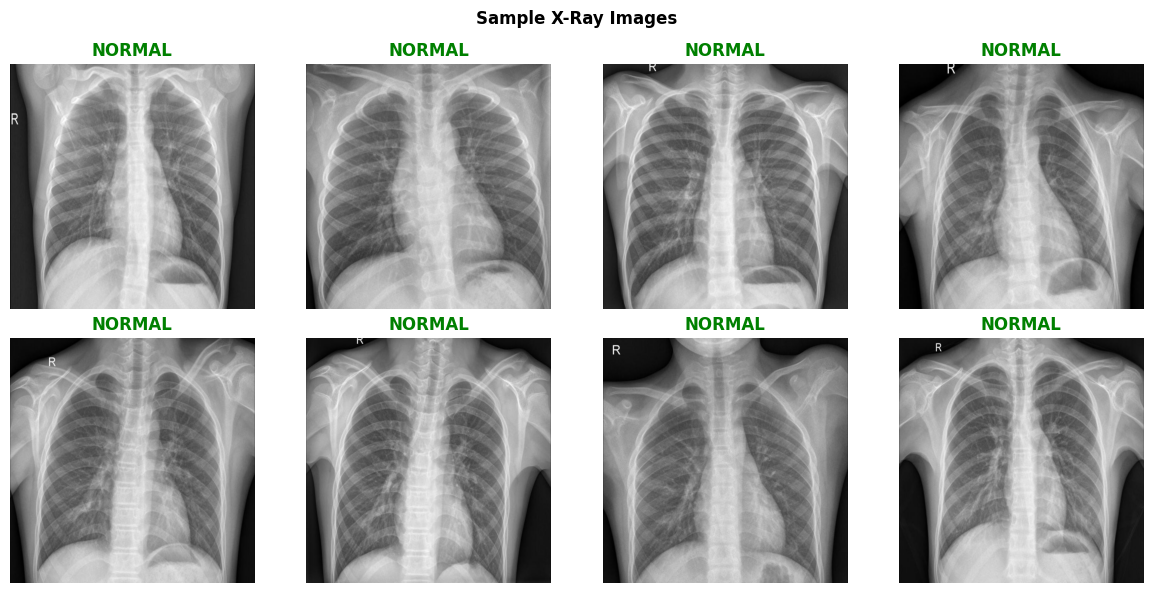

In [9]:
# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    sample = dataset['train'][i]
    img = sample['image']
    label = class_names[sample['labels']]
    ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
    ax.set_title(label, color='red' if 'PNEUMONIA' in label else 'green', fontweight='bold')
    ax.axis('off')
plt.suptitle('Sample X-Ray Images', fontweight='bold')
plt.tight_layout(); plt.show()

##  Create PyTorch Dataset & DataLoaders

In [ ]:
# Custom PyTorch Dataset for HuggingFace data
class ChestXrayDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['labels']
        
        # Convert to RGB if grayscale (some images might be RGB)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("Custom Dataset class defined")

✅ Custom Dataset class defined


### 5.  Data Preprocessing / تجهيز البيانات
Before images go into the AI, they need to be prepared:
1.  **Grayscale**: X-rays are black and white, so we ensure they have 1 color channel (not 3 like RGB).
2.  **Resize**: Force all images to be exactly 128x128 pixels.
3.  **ToTensor**: Convert images into numbers (Tensors) that the computer can understand.
4.  **Collate Function**: A helper to bundle images together into batches of 32.

> **Weighted Sampler**: Since we might have more Pneumonia cases than Normal ones, the AI might get lazy and guess "Pneumonia" all the time. We use a "Weighted Sampler" to balance this, forcing the model to pay equal attention to both types during training. (أخذ عينات موزونة لتحقيق التوازن)

In [ ]:
# Data transforms
train_tf = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_tf = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

print("Transforms defined")

✅ Transforms defined


In [12]:
# Create datasets
train_ds = ChestXrayDataset(dataset['train'], train_tf)
val_ds = ChestXrayDataset(dataset['validation'], test_tf)
test_ds = ChestXrayDataset(dataset['test'], test_tf)

# Get labels for weighted sampling
train_labels = [sample['labels'] for sample in dataset['train']]
class_counts = np.bincount(train_labels)
weights = 1. / class_counts
sample_weights = weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

print(f"Class distribution: {dict(zip(class_names, class_counts))}")
print(f"Class weights: {dict(zip(class_names, weights))}")

Class distribution: {'NORMAL': np.int64(1104), 'PNEUMONIA': np.int64(2973)}
Class weights: {'NORMAL': np.float64(0.0009057971014492754), 'PNEUMONIA': np.float64(0.0003363605785401951)}


In [13]:
# Create data loaders
train_loader = DataLoader(train_ds, config.BATCH_SIZE, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_ds, config.BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, config.BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 128 | Val batches: 37 | Test batches: 19


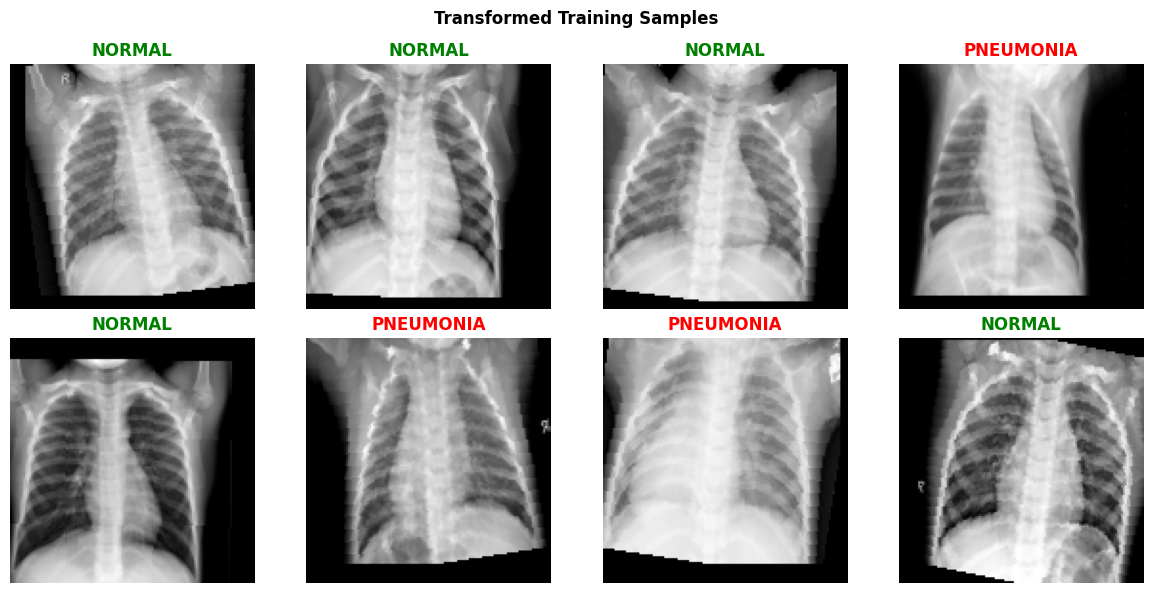

In [14]:
# Visualize transformed samples
imgs, lbls = next(iter(train_loader))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i].squeeze()*0.5+0.5, cmap='gray'); ax.axis('off')
    ax.set_title(class_names[lbls[i]], color='red' if lbls[i]==1 else 'green', fontweight='bold')
plt.suptitle('Transformed Training Samples', fontweight='bold')
plt.tight_layout(); plt.show()

## CNN Model

### 6.  The Model (CNN) / النموذج العصبي
This is the "brain" of our project. It's a Convolutional Neural Network.
*   **Conv Layer (طبقة تلافيفية)**: Scans the image to find features like edges, curves, and cloudy spots.
*   **ReLU**: An activation function that helps the model learn complex patterns (adds non-linearity).
*   **MaxPool**: Shrinks the image to verify impactful features and reduce computation (Pooling). (تجميع لتقليل الأبعاد)
*   **Classifier (Head)**: The final part that takes all features and decides: Normal or Pneumonia?

In [15]:
class PneumoniaCNN(nn.Module):
    def __init__(self, img_size=128):
        super().__init__()
        def block(inc, outc): return nn.Sequential(
            nn.Conv2d(inc, outc, 3, padding=1), nn.BatchNorm2d(outc), 
            nn.ReLU(True), nn.MaxPool2d(2), nn.Dropout2d(0.25))
        
        self.features = nn.Sequential(block(1,32), block(32,64), block(64,128), block(128,256))
        flat = 256 * (img_size//16)**2
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(flat, 256), nn.BatchNorm1d(256), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(True), nn.Dropout(0.5), 
            nn.Linear(128, 1), nn.Sigmoid())
    
    def forward(self, x): 
        return self.classifier(self.features(x))

model = PneumoniaCNN(config.IMG_SIZE).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 4,617,153


In [ ]:
# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=config.LR)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3
)

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience, self.counter, self.best_loss, self.best_model = patience, 0, None, None
    def __call__(self, loss, model):
        if self.best_loss is None or loss < self.best_loss:
            self.best_loss, self.best_model, self.counter = loss, copy.deepcopy(model.state_dict()), 0
        else: self.counter += 1
        return self.counter >= self.patience

early_stop = EarlyStopping(5)
print("Training setup complete")

✅ Training setup complete


## Training

### 7.  Training / التدريب
This works essentially like a loop:
1.  **Feed** images to the model.
2.  **Compare** the model's guess to the actual answer.
3.  **Calculate Loss** (Error): How wrong was the model? (حساب الخطأ)
4.  **Backpropagation**: Go back and adjust the model's internal knobs (weights) to reduce the error next time. (الانتشار العكسي لتصحيح الأخطاء)
5.  **Scheduler**: Gradually reduces the learning rate if the model stops improving, to fine-tune the learning.

**Early Stopping (التوقف المبكر)**: If the model stops improving on the validation set, we stop training early to avoid "Overfitting" (saving the model from memorizing instead of learning).

In [ ]:
print("="*50)
print("STARTING TRAINING")
print("="*50)

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(config.EPOCHS):
    # Train
    model.train(); train_loss, correct, total = 0, 0, 0
    for imgs, lbls in tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False):
        imgs, lbls = imgs.to(device), lbls.float().unsqueeze(1).to(device)
        optimizer.zero_grad(); out = model(imgs); loss = criterion(out, lbls)
        loss.backward(); optimizer.step()
        train_loss += loss.item()*imgs.size(0)
        correct += ((out>0.5)==lbls).sum().item(); total += lbls.size(0)
    
    # Validate
    model.eval(); val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.float().unsqueeze(1).to(device)
            out = model(imgs); val_loss += criterion(out, lbls).item()*imgs.size(0)
            val_correct += ((out>0.5)==lbls).sum().item(); val_total += lbls.size(0)
    
    tl, ta = train_loss/total, correct/total
    vl, va = val_loss/val_total, val_correct/val_total
    history['train_loss'].append(tl); history['train_acc'].append(ta)
    history['val_loss'].append(vl); history['val_acc'].append(va)
    
    print(f'Epoch {epoch+1:2d}: Train[loss={tl:.4f}, acc={ta:.4f}] Val[loss={vl:.4f}, acc={va:.4f}]')
    
    scheduler.step(vl)
    if va >= max(history['val_acc']): 
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"          Best model saved!")
    
    if early_stop(vl, model): 
        print("\nEarly stopping!"); 
        model.load_state_dict(early_stop.best_model); 
        break

print("\nTraining complete!")

🏋️ STARTING TRAINING


Epoch 1:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  1: Train[loss=0.4498, acc=0.7967] Val[loss=0.3232, acc=0.8515]
         💾 Best model saved!


Epoch 2:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  2: Train[loss=0.3090, acc=0.8764] Val[loss=0.1785, acc=0.9322]
         💾 Best model saved!


Epoch 3:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  3: Train[loss=0.2777, acc=0.8938] Val[loss=0.1556, acc=0.9442]
         💾 Best model saved!


Epoch 4:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  4: Train[loss=0.2427, acc=0.9039] Val[loss=0.1366, acc=0.9536]
         💾 Best model saved!


Epoch 5:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  5: Train[loss=0.2544, acc=0.8989] Val[loss=0.1195, acc=0.9571]
         💾 Best model saved!


Epoch 6:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  6: Train[loss=0.2000, acc=0.9232] Val[loss=0.2065, acc=0.9142]


Epoch 7:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  7: Train[loss=0.2118, acc=0.9242] Val[loss=0.1644, acc=0.9399]


Epoch 8:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  8: Train[loss=0.2152, acc=0.9188] Val[loss=0.1698, acc=0.9245]


Epoch 9:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch  9: Train[loss=0.2332, acc=0.9095] Val[loss=0.1401, acc=0.9536]


Epoch 10:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 10: Train[loss=0.2152, acc=0.9218] Val[loss=0.1492, acc=0.9451]

⏹️ Early stopping!

✅ Training complete!


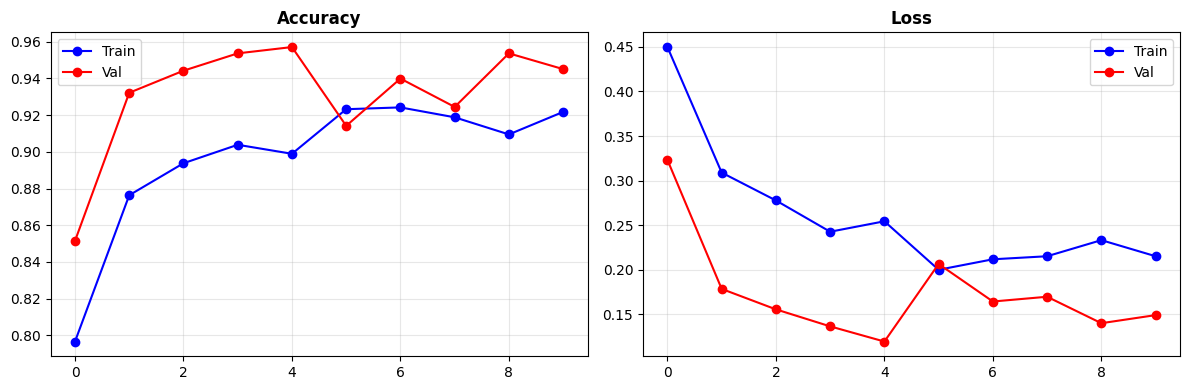

In [20]:
# Plot history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(history['train_acc'], 'b-o', label='Train')
ax1.plot(history['val_acc'], 'r-o', label='Val')
ax1.set_title('Accuracy', fontweight='bold'); ax1.legend(); ax1.grid(alpha=0.3)
ax2.plot(history['train_loss'], 'b-o', label='Train')
ax2.plot(history['val_loss'], 'r-o', label='Val')
ax2.set_title('Loss', fontweight='bold'); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('training_history.png', dpi=150); plt.show()

##  Evaluation

### 8.  Evaluation & Results / التقييم والنتائج
After training, we give the model a final exam using the **Test Set** (images it has never seen before).
*   **Accuracy (الدقة)**: The percentage of correct guesses.
*   **Confusion Matrix (مصفوفة الارتباك)**: shows exactly where the model made mistakes.
    *   **TP (True Positive)**: Correctly predicted Pneumonia.
    *   **TN (True Negative)**: Correctly predicted Normal.
    *   **FP (False Positive)**: Predicted Pneumonia but patient is healthy (False Alarm).
    *   **FN (False Negative)**: Predicted Healthy but patient has Pneumonia (Dangerous!).

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth')); model.eval()

# Evaluate on test set
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc='Testing'):
        out = model(imgs.to(device)).cpu()
        y_prob.extend(out.numpy())
        y_pred.extend((out>0.5).numpy())
        y_true.extend(lbls.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()
y_prob = np.array(y_prob).flatten()

print(f"\nTest Accuracy: {(y_pred==y_true).mean():.4f}")
print("\n" + classification_report(y_true, y_pred, target_names=class_names))

Testing:   0%|          | 0/19 [00:00<?, ?it/s]


📊 Test Accuracy: 0.9278

              precision    recall  f1-score   support

      NORMAL       0.87      0.88      0.88       171
   PNEUMONIA       0.95      0.95      0.95       411

    accuracy                           0.93       582
   macro avg       0.91      0.91      0.91       582
weighted avg       0.93      0.93      0.93       582



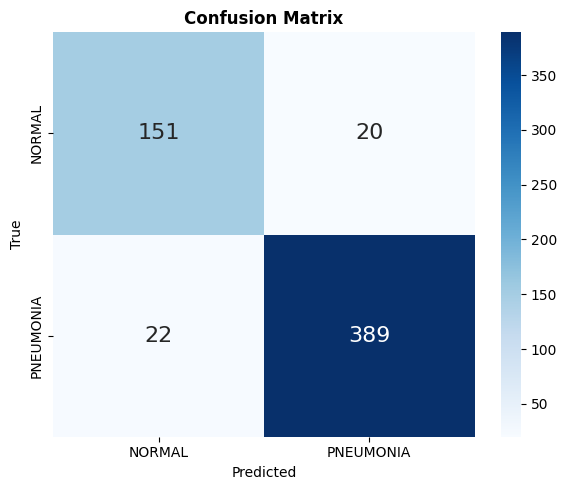


Sensitivity (Recall): 0.9465
Specificity: 0.8830


In [22]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, annot_kws={'size':16})
plt.title('Confusion Matrix', fontweight='bold'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.savefig('confusion_matrix.png', dpi=150); plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")

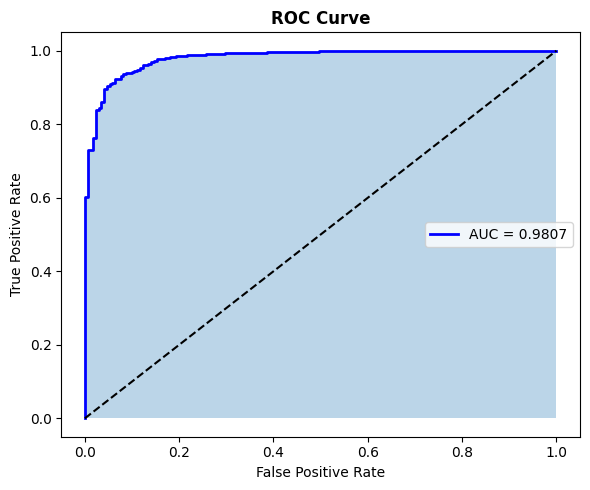

AUC Score: 0.9807


In [23]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--'); plt.fill_between(fpr, tpr, alpha=0.3)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontweight='bold'); plt.legend()
plt.tight_layout(); plt.savefig('roc_curve.png', dpi=150); plt.show()
print(f"AUC Score: {roc_auc:.4f}")

### 9.  Prediction / التنبؤ
We take a few random images from the test set and ask the model to predict them, showing the confidence (probability) of its decision.

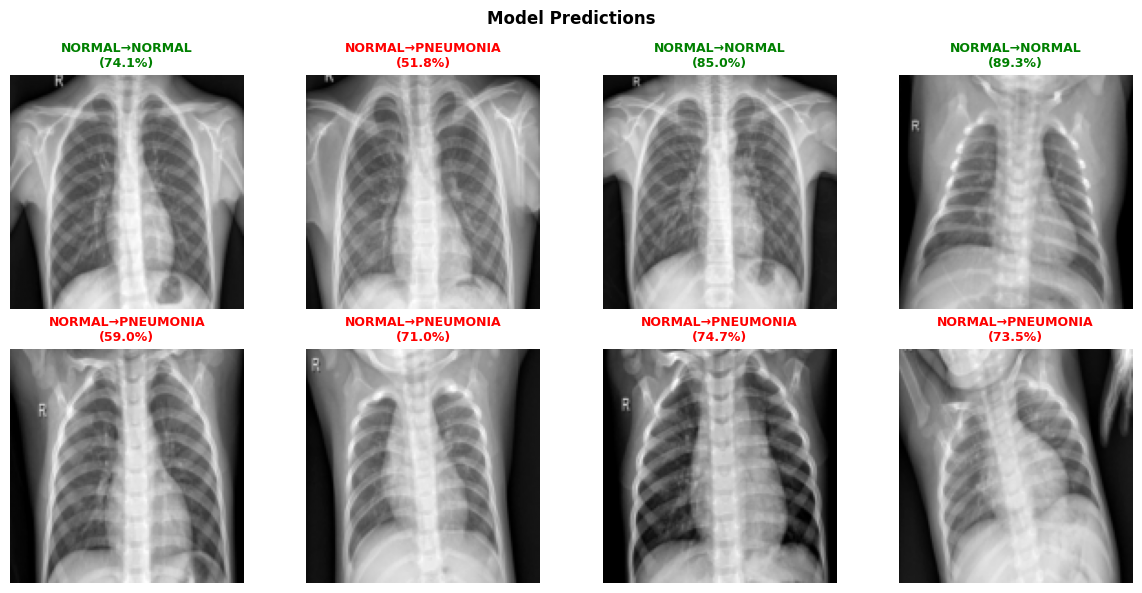

In [24]:
# Sample predictions
imgs, lbls = next(iter(test_loader))
with torch.no_grad(): preds = model(imgs.to(device)).cpu()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i].squeeze()*0.5+0.5, cmap='gray'); ax.axis('off')
    true = class_names[lbls[i]]
    pred = class_names[1] if preds[i]>0.5 else class_names[0]
    prob = preds[i].item() if preds[i]>0.5 else 1-preds[i].item()
    color = 'green' if true==pred else 'red'
    ax.set_title(f'{true}→{pred}\n({prob:.1%})', color=color, fontweight='bold', fontsize=9)
plt.suptitle('Model Predictions', fontweight='bold')
plt.tight_layout(); plt.savefig('predictions.png', dpi=150); plt.show()

In [ ]:
# Save final model
torch.save(model.state_dict(), 'pneumonia_final.pth')  #Only the learned parameters (weights & biases)
torch.save(model, 'pneumonia_complete.pth')             #Entire model (architecture + parameters), ready-made object

print("="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Test Accuracy: {(y_pred==y_true).mean():.4f}")
print(f"AUC Score: {roc_auc:.4f}")
print(f"\nModels saved: pneumonia_final.pth, pneumonia_complete.pth")
print("\nProject Complete!")

📊 FINAL RESULTS
Test Accuracy: 0.9278
AUC Score: 0.9807

💾 Models saved: pneumonia_final.pth, pneumonia_complete.pth

🎉 Project Complete!


In [ ]:
#rebuildable, safer copy, includes metadata, can be easily loaded, Saving instructions to rebuild the machine
torch.save({
    'model_state': model.state_dict(),
    'model_name': 'DenseNet121',
    'num_classes': 2,
    'img_size': 224,
    'class_names': ['NORMAL', 'PNEUMONIA']
}, 'pneumonia_checkpoint.pth')
